In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.io.wavfile as spw
import time
from scipy import ndimage
import cv2
from pylab import *
from scipy import signal

# Question 1

In [4]:
corwave = spw.read('/Users/jacobeverly/Documents/DSP/HW2/wav-files/Corcovado.wav')

In [5]:
cor_arr = np.array(corwave[1][:,0])
fs = (corwave[0])

In [108]:
def spectrogram(x,fs,N,L):
    
    win = np.zeros(N)
    
    #Nyquist rate
    win[0:int(N/2)] = np.linspace(0,1,int(N/2))
    win[int(N/2):] = np.linspace(1,0,int(N/2))
    
    t = np.linspace(0,x.shape[0]-N,x.shape[0]//(N-L),dtype = np.int32)
    spec = np.zeros([t.shape[0],N],dtype= np.complex256)
    
    for j,i in enumerate(t):
        
        sample = x[i:i+N]
        sample = sample*win
        spec[j,:]= np.fft.fftshift(np.fft.fft(sample,n=N))
    f = np.fft.fftshift(np.fft.fftfreq(N,d=fs))

    return t, f, spec

In [109]:
N=1024
L = 50
t,f,spec = spectrogram(cor_arr,1/fs,N,L)
abs_spec = 20*np.log10(np.abs(spec))

/var/folders/y1/wt0h1yhn5hxd3qg29h4rkdgm0000gn/T/ipykernel_1091/2363337875.py:4: RuntimeWarning: divide by zero encountered in log10
  abs_spec = 20*np.log10(np.abs(spec))


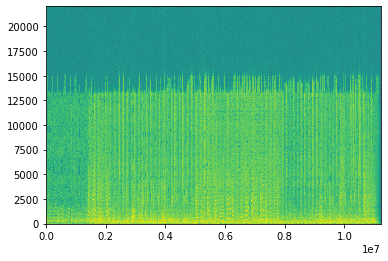

In [88]:
N=1024
fig,ax = plt.subplots(1)
ax.pcolormesh(t,f[N//2:],abs_spec.T[N//2:])

In [102]:
def invspectrogram(spec,N,L):
    
    win = np.zeros(N)

    #Nyquist rate
    win[0:int(N/2)] = np.linspace(0,1,int(N/2))
    win[int(N/2):] = np.linspace(1,0,int(N/2))
    recon_signal = np.zeros(spec.shape[0]*(N-L)+L,dtype=np.complex128)
    
    for i in range(spec.shape[0]):
        
        recon_signal[i*(N-L):i*(N-L)+N] = np.fft.ifft(np.fft.fftshift(spec[i,:]))/win
    
    return recon_signal

/var/folders/y1/wt0h1yhn5hxd3qg29h4rkdgm0000gn/T/ipykernel_1091/429202783.py:9: RuntimeWarning: invalid value encountered in true_divide
  recon_signal[i*(N-L):i*(N-L)+N] = np.fft.ifft(np.fft.fftshift(spec[i,:]))/win
/var/folders/y1/wt0h1yhn5hxd3qg29h4rkdgm0000gn/T/ipykernel_1091/429202783.py:9: RuntimeWarning: divide by zero encountered in true_divide
  recon_signal[i*(N-L):i*(N-L)+N] = np.fft.ifft(np.fft.fftshift(spec[i,:]))/win
/Users/jacobeverly/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


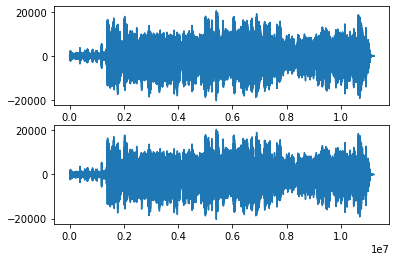

In [104]:
N = 1024
L = 50
fig,ax = plt.subplots(2)
recon_signal = invspectrogram(spec,N,L)
ax[0].plot(recon_signal)
ax[1].plot(cor_arr)

# Question 2

In [45]:
def t1_fir(N, ws, A):
    
    M = int((N-1)/2)
    M_vals = np.arange(1,M+1,1)
    F = np.ones([M+1,int(ws.shape[0])])
    F[1:,:] = 2*np.cos(M_vals[:,None]@ws[None,:])
    x = np.linalg.pinv(F).T@As
    filt = np.zeros(N)
    filt[0:M] = np.flip(x[1:])
    filt[M:] = x

    return filt
    
    

In [89]:
N= 101
L = 1000
ws = np.linspace(0,np.pi,L)
As = np.zeros(len(ws))
#desired amplitudes
As[0:L//8] = 1
As[L//8:L//4] = 2
As[L//4:(3*L//8)] = 1
As[(3*L//8):L//2] = 0.5
filt = t1_fir(N,ws,As)

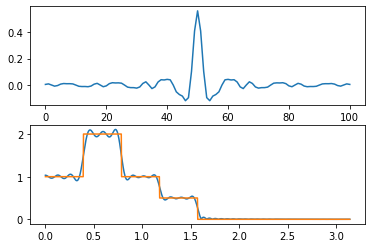

In [90]:
freq = np.fft.fft(filt,n=2000)

fig,ax = plt.subplots(2)
ax[0].plot(filt)
ax[1].plot(ws,np.abs(freq[:L]))
ax[1].plot(ws,As)

In [42]:
#Low pass Filter 
N= 101
L = 1000
ws = np.linspace(0,np.pi,L)
As = np.zeros(len(ws))
As[0:L//16] = 1

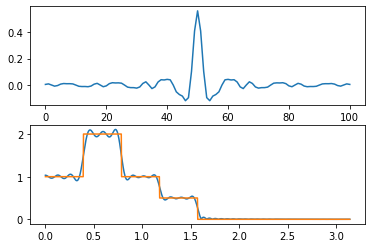

In [91]:
filt = t1_fir(N,ws,As)
freq = np.fft.fft(filt,n=L*2)

fig,ax = plt.subplots(2)
ax[0].plot(filt)
ax[1].plot(ws,np.abs(freq[:L]))
ax[1].plot(ws,As)

In [43]:
#Comparasion Implementation
sp_filt = signal.firls(N,ws/np.pi,As)
sp_freq = np.fft.fft(sp_filt,n=2000)

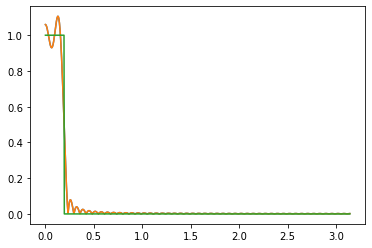

In [44]:
fig,ax = plt.subplots(1)
ax.plot(ws,np.abs(fir_filt_freq[:L]))
ax.plot(ws,np.abs(sp_freq)[:L])
ax.plot(ws,As)

# Question 3

In [48]:
def RandomMask(x,f):
    mask = np.ones(x.shape)
    rand = np.random.sample(x.shape)>f/100
    res1 = rand*x
    res2 = rand.astype(int)
    return res1 , res2

In [63]:
def ImageGrad(x):
    grad_x = ndimage.sobel(x)
    return grad_x

In [62]:
def ReconLoss(x,xmask,mask,lamb):
    lamb >= 0
    xgrad = ImageGrad(x)
    res = np.sum(np.square(x*mask - xmask)) + np.sum(np.abs(xgrad)*x)
    return res

In [55]:
def ImageMerge(x1,x2,alp):
    x1.shape == x2.shape
    res = alp*x1+(1-alp)*x2
    return res

In [115]:
def ImageMergeWithMask(x1,x2,mask,alp):
    x1.shape == x2.shape
    res = mask*x1+(1-mask)*(alp*x1+(1-alp)*x2)
    return res

In [119]:
#upload images
x= cv2.imread('/Users/jacobeverly/Documents/DSP/HW5/Files-1/X.png',cv2.IMREAD_GRAYSCALE)
y = cv2.imread('/Users/jacobeverly/Documents/DSP/HW5/Files-1/Y.png',cv2.IMREAD_GRAYSCALE)

In [168]:
alp = np.linspace(0,1,100)
lam= 20
merge_loss=[]
merge_mask_loss=[]
x_loss = None
x_mask_loss = None
x_loss_img = None
x_loss_mask_img = None
for i in alp:
    x_merge = ImageMerge(x,y,i)
    loss = ReconLoss(x_merge,x_masked,mask,20)
    merge_loss.append(loss)
    if x_loss==None or loss<x_loss:
        x_loss = loss
        x_loss_img = x_merge
    merge_mask = ImageMergeWithMask(x,y,mask,i)
    loss = ReconLoss(merge_mask,x_masked,mask,20)
    merge_mask_loss.append(loss)
    if x_mask_loss==None or loss<x_mask_loss:
        x_mask_loss = loss
        x_loss_mask_img = merge_mask

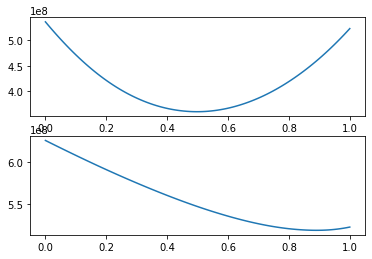

In [159]:
fig,ax = plt.subplots(2)
ax[0].plot(alp,merge_loss)
ax[1].plot(alp,merge_mask_loss)

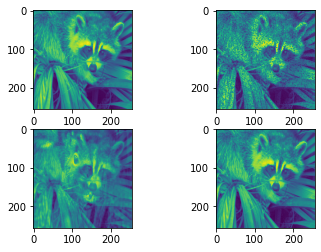

In [169]:
fig,ax = plt.subplots(2,2)
ax[0][0].imshow(x)
ax[0][1].imshow(x_masked)
ax[1][0].imshow(x_loss_img)
ax[1][1].imshow(x_loss_mask_img)